In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import pandas as pd
import nibabel as nib

import torch
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F

import sklearn
import sklearn.metrics

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
import pandas as pd
import nibabel as nib

import torch
from torch.utils.data import DataLoader, Dataset, random_split

import sklearn
import sklearn.metrics

# Preprocessing

## Data handling

### Global variables

In [2]:
dataset_dir = Path(os.getcwd()) / "Datasets" / "ADNI" / "ADNI1"
print(dataset_dir)

imgs_dir = dataset_dir / "Images"
masks_dir = dataset_dir / "SegmentationMasks"
store_dir = dataset_dir / "InputImages"

print(imgs_dir)
print(masks_dir)

csv_files = dataset_dir.glob("**/*.csv")
for csv_file in csv_files:
    csv_data = csv_file
    
print(csv_data)
df = pd.read_csv(csv_data)

d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\Images
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\SegmentationMasks
d:\Facultate\anul_3\ELL\Code\Datasets\ADNI\ADNI1\ADNI1_T1_Imgs_CN-MCI-AD_5_18_2024.csv


In [3]:
df.head(7)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I118692,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,11/02/2006,NiFTI,5/17/2024
1,I64025,002_S_0295,CN,M,86,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/25/2007,NiFTI,5/18/2024
2,I118671,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,4/18/2006,NiFTI,5/18/2024
3,I123685,002_S_0295,CN,M,87,m24,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,7/23/2008,NiFTI,5/17/2024
4,I150177,002_S_0295,CN,M,88,m36,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/22/2009,NiFTI,5/17/2024
5,I40966,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,11/02/2006,NiFTI,5/17/2024
6,I45108,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,5/18/2024


In [226]:
#df.head(7)
(
    df.groupby("Subject")
)
print(df.count())

Image Data ID    2720
Subject          2720
Group            2720
Sex              2720
Age              2720
Visit            2720
Modality         2720
Description      2720
Type             2720
Acq Date         2720
Format           2720
Downloaded       2720
dtype: int64


In [ ]:
# df.columns
arr = df.head(7)["Acq Date"].to_numpy()
print(arr)

Plan:
- take date from dataframe
- load original image from taht date
- load segmentation mask from that date
- if both exist, apply the mask on the image and store the result in new directory

In [5]:
def convert_date(acq_date):
    parsed_date = datetime.strptime(acq_date, f"%m/%d/%Y")
    return parsed_date.strftime(f"%Y-%m-%d")

def search_subdirectories(base_directory, date):
    base_path = Path(base_directory)
    matching_subdirs = [subdir for subdir in base_path.rglob('*') if subdir.is_dir() and subdir.name.startswith(date)]
    if matching_subdirs == []:
        return None
    return matching_subdirs[0] # can return multiple, so only first

def plot_segmentation_steps(img_arr, mask_arr, segmented_arr, slice_number):
    mask_arr = np.transpose(mask_arr, (2, 1, 0))
    for i in range(mask_arr.shape[2]): # Mask and image have different orientations
        mask_arr[:, :, i] = np.rot90(mask_arr[:, :, i], k=2)
    # !planes (i, j, k)
    # i - saggital
    # j - coronal
    # k - horizontal

    mask_slice = mask_arr[:, :, slice_number]
    image_slice = img_arr[:, :, slice_number]
    segmented_slice = segmented_arr[:, :, slice_number]

    # mask_slice = mask_arr[:, slice_number, :]
    # image_slice = img_arr[:, slice_number, :]
    # segmented_slice = segmented_arr[:, slice_number, :]

    # mask_slice = mask_arr[slice_number, :, :]
    # image_slice = img_arr[slice_number, :, :]
    # segmented_slice = segmented_arr[slice_number, :, :]

    plt.figure()

    fig, axes = plt.subplots(1, 3)

    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    axes[0].imshow(mask_slice.T, cmap='gray', origin='lower')
    axes[0].set_title("(a)")
    #plt.show()
    axes[1].imshow(image_slice.T, cmap='gray', origin='lower')
    axes[1].set_title("(b)")
    #plt.show()
    axes[2].imshow(segmented_slice.T, cmap='gray', origin='lower')
    axes[2].set_title("(c)")
    plt.tight_layout
    plt.show()

def plot_axes(img, slice_number):
    slice1 = img[slice_number, :, :] # horizontal
    slice2 = img[:, slice_number, :] # coronal
    print(f"coronal shape = {slice2.shape}")
    slice3 = img[:, :, slice_number] # saggital
    plt.figure()

    fig, axes = plt.subplots(1, 3)

    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    axes[0].imshow(slice1.T, cmap='gray', origin='lower')
    axes[0].set_title("(a)")
    #plt.show()
    axes[1].imshow(slice2.T, cmap='gray', origin='lower')
    axes[1].set_title("(b)")
    #plt.show()
    axes[2].imshow(slice3.T, cmap='gray', origin='lower')
    axes[2].set_title("(c)")
    plt.tight_layout
    plt.show()

def apply_mask(img_arr, mask_arr):
    img_arr = nib.load(img_path).get_fdata()
    mask_arr = nib.load(mask_path).get_fdata()

    mask_arr = np.transpose(mask_arr, (2, 1, 0))
    segmented_arr = img_arr.copy()

    if img_arr.shape != mask_arr.shape:
        return None

    for i in range(mask_arr.shape[2]): # Mask and image have different orientations
        mask_arr[:, :, i] = np.rot90(mask_arr[:, :, i], k=2)

    segmented_arr[mask_arr == 0] = 0
    return segmented_arr


In [ ]:
i = 1
# ! this took like 50 minutes
for index, row in df.iterrows():
    
    # converting date formats to match the directory formats for easier finding
    acq_date = row["Acq Date"]
    date = convert_date(acq_date)
    # print(parsed_date) # ex: 2006-11-02
    subject = row["Subject"]
    
    # skip already saved mask applications
    if os.path.exists(f"{store_dir}/{subject}__{date}.nii"):
        continue

    subject_img_dir = imgs_dir / subject
    subject_mask_dir = masks_dir / subject

    img_subdir = search_subdirectories(subject_img_dir, date)
    mask_subdir = search_subdirectories(subject_mask_dir, date)

    # only care if we find both img and mask for a subject and a date
    if img_subdir == None or mask_subdir == None:
        continue
    # print(img_subdir)

    # **\* to skip over another subdir (image_id one)
    # have transform to list, .glob() is not iterable
    img_path = list(img_subdir.glob(f"**\*.nii"))[0] 
    mask_path = list(mask_subdir.glob(f"**\*.nii"))[0] 
    
    img_arr = nib.load(img_path).get_fdata()
    mask_arr = nib.load(mask_path).get_fdata()

    segmented_arr = apply_mask(img_arr, mask_arr)
    if segmented_arr is None:
        continue
    
    nifti_img = nib.Nifti1Image(segmented_arr, np.eye(4))
    nib.save(nifti_img, f"{store_dir}/{subject}__{date}.nii")

    if i == 1:
        # plot_segmentation_steps(img_arr, mask_arr, segmented_arr, 80)
        # plot_axes(segmented_arr, 80)
        # nifti_img = nib.Nifti1Image(segmented_arr, np.eye(4))
        # nib.save(nifti_img, f"{store_dir}/{subject}__{date}.nii")
        # test_arr = nib.load(f"{store_dir}/{subject}__{date}.nii").get_fdata()
        # plot_axes(test_arr, 80)
        pass

    i = i + 1

Check the segmentation and storing was done properly

In [6]:
input_dir = store_dir
print(f"valid entries after preprocessing: {len([subdir for subdir in input_dir.iterdir()])}")

valid entries after preprocessing: 2159


# Planes (i, j, k)
- i - saggital
- j - coronal
- k - horizontal

In [ ]:
i = 0
for input_img_path in input_dir.iterdir():
    if i > 10:
        continue
    input_img = nib.load(input_img_path).get_fdata()
    input_img
    plot_axes(input_img, 80)
    i = i + 1

# Plan
- dataloader and 

In [7]:
# print(df.head(1))

def read_img(parent_dir, subject, date):
    input_img_path = parent_dir / f"{subject}__{date}.nii"
    if not os.path.exists(input_img_path):
        return None
    input_img = nib.load(input_img_path).get_fdata()
    return input_img
    # print(input_img.shape)
    # plot_axes(input_img, 130)    

def plot_16_coronal_slices(img, slice_number):
    slices = []
    for slice_no in range(slice_number - 7, slice_number + 9):
        slices.append(img[:, slice_no, :])# coronal

    # print(f"coronal shape = {slice2.shape}")
    plt.figure()

    fig, axes = plt.subplots(4, 4)

    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    # for ax in axes:
        # ax.set_xticks([])
        # ax.set_yticks([])

    for i in range(4):
        for j in range(4):
            axes[i][j].imshow(slices[i * 4 + j].T, cmap='gray', origin='lower')
            # axes[i][j].set_title(f"slice {i * 4 + j + 1}")
    plt.tight_layout
    plt.show()

def read_image(path):
    input_img = nib.load(path).get_fdata()
    return input_img

def separate_16_coronal_slices(img, slice_number):
    slices = []
    for slice_no in range(slice_number - 14, slice_number + 16):
        slices.append(img[:, slice_no, :]) # coronal
    return slices


In [ ]:
dict = {}

# only consider first shape
input_shapes = {
    (256, 256, 166) : 128,
    # (192, 192, 160) : 86,
    # (240, 256, 160) : 128
}

i = 0
for index, row in df.iterrows():
    subject = row["Subject"]
    date = convert_date(row["Acq Date"])
    input_img = read_img(input_dir, subject, date)
    if input_img is None or input_img.shape not in input_shapes.keys():
        continue

    # print(input_shapes[input_img.shape])

    if i == 1:
        slices = separate_16_coronal_slices(input_img, 128)
        print(slices[0].shape)
        # plot_axes(input_img, input_shapes[input_img.shape])
        # plot_16_coronal_slices(input_img, input_shapes[input_img.shape])
        pass
    i = i + 1
    # plot_axes(input_img, input_shapes[input_img.shape])

    # computation to see count for each image shape
    # if input_img.shape not in dict.keys():
    #     dict[input_img.shape] = 1
    # else:
    #     dict[input_img.shape] = dict[input_img.shape] + 1

In [ ]:
# which middle slice to consider depending on each input size
input_shapes = {
    (256, 256, 166) : 128,
    # (192, 192, 160) : {86},
    # (240, 256, 160) : {128}
}

for key in dict.keys():
    print(f"shape = {key}, count = {dict[key]}")

# storing and Upsampling AD cases

coronal shape = (256, 166)


<Figure size 640x480 with 0 Axes>

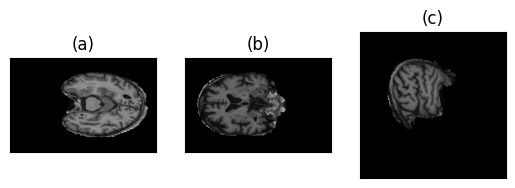

<Figure size 640x480 with 0 Axes>

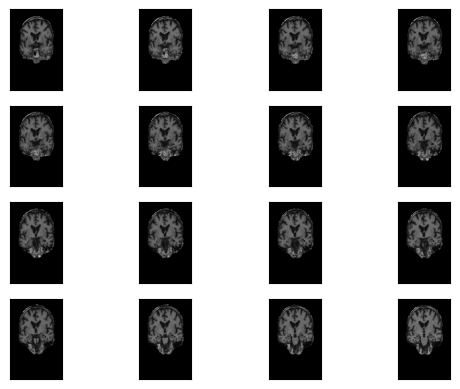

600
113
600
600


In [160]:
count = 0
img_paths = []
labels = []
additional_data = [] # (sex, age)

limit = 300
cn_limit = 0
mci_limit = 0
ad_limit = 0

input_shapes = {
    (256, 256, 166) : 128,
    # (192, 192, 160) : {86},
    # (240, 256, 160) : {128}
}

i = 0
for index, row in df.iterrows():
    group = row["Group"]
    # print(group)
    # print(count)
    
    subject = row["Subject"]
    date = convert_date(row["Acq Date"])
    input_img = read_img(input_dir, subject, date)
    
    # if image doesn't exist or doesn't follow shape criteria don't add it
    if input_img is None or input_img.shape not in input_shapes.keys():
        continue

    if i == 1:
        plot_axes(input_img, input_shapes[input_img.shape])
        plot_16_coronal_slices(input_img, input_shapes[input_img.shape])
    i = i + 1
    if group == "MCI":
        continue
    
    if group == "CN":
        if cn_limit == limit:
            continue
        cn_limit = cn_limit + 1
    # elif group == "MCI":
    #     if mci_limit == limit:
    #         continue
    #     mci_limit = mci_limit + 1
    else:
        if ad_limit == limit:
            continue
        ad_limit = ad_limit + 1 

    sex = 0 if row["Sex"] == 'M' else 1
    age = row["Age"]
    additional_data.append((sex, age))
    # print(additional_data)

    input_img_path = input_dir / f"{subject}__{date}.nii"
    img_paths.append(input_img_path)
    labels.append(row["Group"])


num_cn = 300
num_mci = 187
num_ad = 187

upsample_count = num_cn - num_ad
already_inserted = []

for idx, data in enumerate(img_paths):
    group = labels[idx]
    if group == 'AD' and upsample_count > 0:
        upsample_count = upsample_count - 1
        if idx not in already_inserted:
            already_inserted.append(idx)
            img_paths.append(img_paths[idx])
            labels.append(labels[idx])
            count = count + 1
            additional_data.append(additional_data[idx])

print(len(additional_data))
print(count)
print(len(labels))
#print(labels[:10])
#print(img_paths[:5])

print(len(labels))

# Data spread
- 1112 images of shape[0]
- 333 Cognitive normal (30%)
- 592 Mild Cognitive Impairment(53.2%)
- 187 Alzheimer's Disease(16.8%)

In [10]:
labels_np = np.array(labels)
cn_count = np.sum(labels_np == 'CN')
mci_count = np.sum(labels_np == 'MCI')
ad_count = np.sum(labels_np == 'AD')
total_count = cn_count + mci_count + ad_count

print(f"CN cases  = {cn_count} ({cn_count * 100 / total_count}%) \nMCI cases = {mci_count} ({mci_count * 100 / total_count}%) \nAD cases  = {ad_count} ({ad_count * 100 / total_count}%)") 

CN cases  = 300 (61.60164271047228%) 
MCI cases = 0 (0.0%) 
AD cases  = 187 (38.39835728952772%)


In [72]:
# input_shapes = {
#     (256, 256, 166) : 128,
#     # (192, 192, 160) : {86},
#     (240, 256, 160) : 128
# }

def min_max_normalize(image, new_min=0, new_max=1):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return normalized_image

def read_image(path):
    input_img = nib.load(path).get_fdata()
    return input_img

def separate_16_coronal_slices(img, slice_number):
    # slices = []
    # for slice_no in range(slice_number - 4, slice_number + 4):
    #     slice = np.rot90(img[:, slice_no, :], k=2)
    #     slice = min_max_normalize(slice)
    #     slices.append(slice) # coronal
    # return slices
    return [np.rot90(img[:, slice_number, :], k=2)]

# Preprocessing plots

168.20305615029835
0.07939779966402305
[array([<Axes: >, <Axes: >], dtype=object)]


<Figure size 640x480 with 0 Axes>

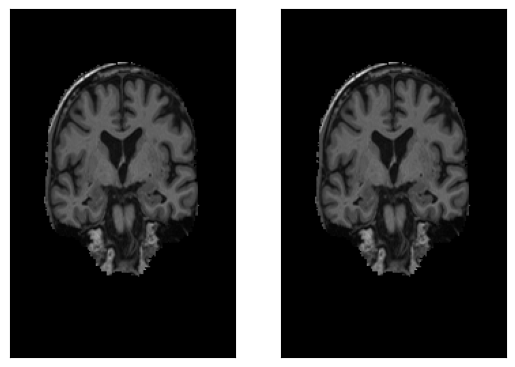

<Figure size 640x480 with 0 Axes>

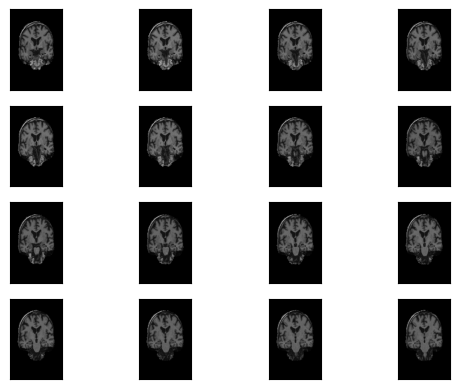

226.45307630161383
0.08832081284235833
[array([<Axes: >, <Axes: >], dtype=object)]


<Figure size 640x480 with 0 Axes>

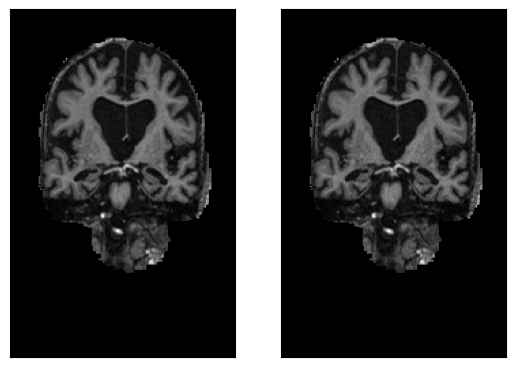

<Figure size 640x480 with 0 Axes>

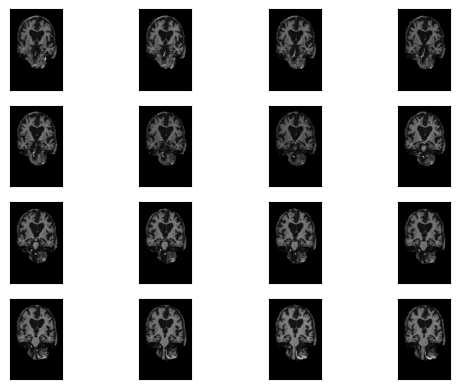

In [219]:
found_ad = False
found_cn = False

def plot_16_coronal_slices(img, slice_number):
    slices = []
    for slice_no in range(slice_number - 7, slice_number + 9):
        slices.append(img[:, slice_no, :])# coronal

    # print(f"coronal shape = {slice2.shape}")
    plt.figure()

    fig, axes = plt.subplots(4, 4)

    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    for i in range(4):
        for j in range(4):
            slice = np.rot90(slices[i * 4 + j], k=2)
            slice = min_max_normalize(slice)
            axes[i][j].imshow(slice, cmap='gray', origin='lower')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

            # axes[i][j].set_title(f"slice {i * 4 + j + 1}")
    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels
    plt.tight_layout
    plt.show()

def plot_normalization(img, slice_number):
    slices = []
    # for slice_no in range(slice_number - 7, slice_number + 9):
    slices.append(np.rot90(img[:, slice_number, :], k=2))# coronal
    slices.append(min_max_normalize(np.rot90(img[:, slice_number, :], k=2)))
    print(np.average(slices[0]))
    print(np.average(slices[1]))
    # print(f"coronal shape = {slice2.shape}")
    plt.figure()

    fig, axes = plt.subplots(1, 2)
    # Create a GridSpec with custom widths and heights

    axes = [axes]
    print(axes)
    plt.xticks([])  # Hide x axis ticks and labels
    plt.yticks([])  # Hide y axis ticks and labels

    for i in range(0, 1):
        for j in range(0, 2):
            axes[i][j].imshow(slices[j], cmap='gray', origin='lower')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

    #         # axes[i][j].set_title(f"slice {i * 4 + j + 1}")
    plt.show()

for idx, path in enumerate(img_paths):
    if idx % 10 == 0:
        # print(img_paths[idx], labels[idx])
        pass
    
    if labels[idx] == 'CN' and found_cn == False:
        found_cn = True
        img = read_image(img_paths[idx])
        slices = separate_16_coronal_slices(img, 128)
        plot_normalization(img, 128)
        plot_16_coronal_slices(img, 128)

    if labels[idx] == 'AD' and found_ad == False:
        found_ad = True
        img = read_image(img_paths[idx])
        slices = separate_16_coronal_slices(img, 128)
        plot_normalization(img, 128)
        plot_16_coronal_slices(img, 128)

In [95]:
class ADNI1_Dataset(Dataset):
    def __init__(self, img_paths, additional_data, labels, label_dict, input_shapes):
        self.img_paths = img_paths
        self.additional_data = additional_data
        self.labels = labels
        self.label_dict = label_dict
        self.input_shapes = input_shapes

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = read_image(self.img_paths[idx])
        coronal_slices = separate_16_coronal_slices(img, self.input_shapes[img.shape])
        coronal_slices = torch.tensor(coronal_slices, dtype=torch.float)
        return coronal_slices, torch.tensor(self.additional_data[idx]), self.label_dict[self.labels[idx]]

label_dict = {
    "CN": 0,
    "AD": 1,
}

dataset = ADNI1_Dataset(img_paths, additional_data, labels, label_dict, input_shapes)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# ResNet

In [96]:
import importlib
import models.ResNet as RN
importlib.reload(RN)

<module 'models.ResNet' from 'd:\\Facultate\\anul_3\\ELL\\Code\\models\\ResNet.py'>

In [97]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
model = RN.ResNet101(device)
#print(model)
# model.Conv2d_1a_3x3.conv = torch.nn.Conv2d(30, model.Conv2d_1a_3x3.conv.out_channels, kernel_size=model.Conv2d_1a_3x3.conv.kernel_size, stride=model.Conv2d_1a_3x3.conv.stride, padding=model.Conv2d_1a_3x3.conv.padding, bias=model.Conv2d_1a_3x3.conv.bias)

model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
model.fc2 = torch.nn.Linear(in_features=model.fc2.in_features, out_features=2, bias=True)
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentu

In [98]:
i = 0

num_epochs = 100

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)


# Total number of samples
total = num_cn + num_ad

# Calculate weights for each class
# weight_cn = total / (2 * num_cn)
# weight_mci = total / (3 * num_mci)
# weight_ad = total / (2 * num_ad)
# class_weights = torch.tensor([weight_cn, weight_ad], dtype=torch.float32).to(device)

# criterion = torch.nn.CrossEntropyLoss(class_weights)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []

In [129]:
for epoch in range(num_epochs):
    print(f"epoch = {epoch + 1}/{num_epochs}")
    train_running_loss = 0
    n = 0
    # don't put (data, labels) here instead of data. it botches the self.labels in the loader for some reason
    acc = 0
    conf_matrix = np.zeros((2, 2))
    for batch_idx, data in enumerate(train_loader):
        n = n + 1
        if batch_idx % 10 == 0:
            print(f"batch id = {batch_idx}")    
            pass
        imgs, additional_data, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        outputs = model(imgs, additional_data)
        # print(outputs.shape)   
        # print(outputs.shape)
        # print(outputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        # if i == 0:
        #    print(data[0].shape)
        #    print(data[1].shape)
        # i = i + 1
        acc = acc + torch.sum(torch.argmax(outputs, dim=1) == labels) / len(labels)
        # print(labels)
        preds = torch.argmax(outputs, dim=1)
        # print(preds)
        conf_matrix += sklearn.metrics.confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy(), labels=np.arange(2))
    
    print(conf_matrix)
    train_losses.append(train_running_loss / n)
    print(f"train loss = {train_running_loss / n}, acc = {acc / n}")



epoch = 1/100
batch id = 0


KeyboardInterrupt: 

In [131]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss
}, 'model_resnet.pth')

In [108]:
test_losses = []

In [130]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = RN.ResNet101(device)
# model.conv1 = torch.nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding, bias=model.conv1.bias)
# model.fc2 = torch.nn.Linear(in_features=model.fc2.in_features, out_features=2, bias=True)
# model.to(device)
# checkpoint = torch.load('model_resnet.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
test_running_loss = 0
conf_matrix = np.zeros((2, 2))
criterion = torch.nn.CrossEntropyLoss()
n = 0
acc = 0
for i, data in enumerate(test_loader):
    if i % 10 == 0:
        print(f"batch_id = {i}")
    n = n + 1
    imgs, additional_data, labels = data[0].to(device), data[1].to(device), data[2].to(device)
    
    outputs = model(imgs, additional_data)
    loss = criterion(outputs, labels)
    loss.backward()
    test_running_loss += loss.item()    

    acc = acc + torch.sum(torch.argmax(outputs, dim=1) == labels) / len(labels)
    conf_matrix += sklearn.metrics.confusion_matrix(labels.cpu().numpy(), torch.argmax(outputs, dim=1).cpu().numpy(), labels=np.arange(2))
    
print(conf_matrix)
print(f"eval loss = {test_running_loss / n}, accuracy = {acc / n}")
test_losses.append(test_running_loss / n)
print(test_losses)

batch_id = 0
batch_id = 10
[[69. 22.]
 [56. 33.]]
eval loss = 0.688165083527565, accuracy = 0.5625
[0.702071487903595, 0.6799054592847824, 0.6787464668353399, 0.6779462844133377, 0.7046463191509247, 0.6820473124583563, 0.6953223198652267, 0.7017315675814947, 0.688165083527565]


260


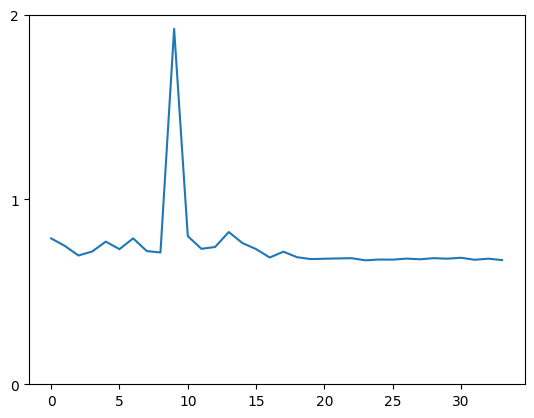

In [158]:
print(len(train_losses))
plt.plot(train_losses[1:35])
_ = plt.yticks(list(range(0,3)))
